In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Data pre-processing

In [13]:
data_dir = "data"

In [3]:
prosumer = pd.read_csv(os.path.join(data_dir, 'prosumer.csv'))
# Get net demand
prosumer['datetime'] = pd.to_datetime(prosumer['datetime'])
# prosumer['net_demand'] = prosumer[prosumer['is_consumption'] == 1].reset_index()['target'] - prosumer[prosumer['is_consumption'] == 0].reset_index()['target']
# net_prosumer = prosumer.drop(columns=['target', 'is_consumption','county','is_business','product_type','data_block_id','row_id','prediction_unit_id']).groupby('datetime').sum()
# Date selected due to corrupted data after
# net_prosumer = net_prosumer[net_prosumer.index < "2022-07-21 10:00:00"]
net_prosumer = prosumer[prosumer['is_consumption'] == 1].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum() - prosumer[prosumer['is_consumption'] == 0].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum()
net_prosumer['demand'] = prosumer[prosumer['is_consumption'] == 1].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum()
net_prosumer['supply'] = prosumer[prosumer['is_consumption'] == 0].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum()
net_prosumer.describe()

,target,demand,supply
count,15312.000000,15312.000000,15312.000000
mean,24491.749526,30356.185163,5864.435638
std,19095.117622,9943.956810,12483.735708
min,-81630.133000,0.000000,0.000000
25%,20476.536000,23726.007750,42.913750
50%,27624.398500,28921.808500,109.283500
75%,35263.906250,36038.074750,3888.608750
max,63251.063000,63354.178000,89930.586000


In [4]:
weather_history = pd.read_csv(os.path.join(data_dir, 'weather_history.csv'))
weather_history['datetime'] = pd.to_datetime(weather_history['datetime'])
weather_history = weather_history.drop(columns=['latitude', 'longitude', 'data_block_id']).groupby("datetime").mean()
weather_history.describe()

,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
count,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000
mean,5.740960,2.240304,0.049620,0.016049,1009.281510,60.912753,46.685981,34.407020,36.051410,4.849868,197.869471,106.490520,64.452931,42.037589
std,7.635356,6.846250,0.118073,0.051131,11.964149,31.213803,33.703470,29.682011,32.114876,1.849202,72.283113,171.397301,122.710267,58.382343
min,-14.283929,-17.221429,0.000000,0.000000,960.000000,0.000000,0.000000,0.000000,0.000000,1.091766,15.598214,0.000000,0.000000,0.000000
25%,-0.054464,-2.624554,0.000000,0.000000,1002.493750,33.589286,13.169643,7.000000,5.348214,3.397321,150.517857,0.901786,0.071429,0.678571
50%,5.192857,1.574107,0.004464,0.000000,1010.561607,67.428571,45.669643,27.553571,28.553571,4.662202,205.928571,10.625000,5.080357,3.830357
75%,10.893304,6.821429,0.038393,0.003750,1017.041071,89.924107,79.053571,57.125000,61.901786,6.162946,248.776786,146.035714,59.808036,75.491071
max,27.278571,19.208929,1.495536,0.898750,1043.284821,100.000000,100.000000,99.964286,100.000000,12.023313,356.303571,780.973214,670.464286,286.678571


In [5]:
weather_forecast = pd.read_csv(os.path.join(data_dir, 'weather_forecast.csv'))
weather_forecast['origin_datetime'] = pd.to_datetime(weather_forecast['origin_datetime'])
weather_forecast['forecast_datetime'] = weather_forecast['origin_datetime'] + pd.to_timedelta(weather_forecast['hours_ahead'], unit='h')
weather_forecast = weather_forecast.drop(columns=['latitude', 'longitude','origin_datetime','hours_ahead','data_block_id']).groupby("forecast_datetime").mean()
weather_forecast.columns = ['24h_forecasted_{}'.format(measurement) for measurement in weather_forecast.columns]
weather_forecast.index = weather_forecast.index.rename('datetime')
weather_forecast = weather_forecast.shift(-1, freq=pd.DateOffset(days=1)).iloc[24:]
weather_forecast.describe()

,24h_forecasted_temperature,24h_forecasted_dewpoint,24h_forecasted_cloudcover_high,24h_forecasted_cloudcover_low,24h_forecasted_cloudcover_mid,24h_forecasted_cloudcover_total,24h_forecasted_10_metre_u_wind_component,24h_forecasted_10_metre_v_wind_component,24h_forecasted_direct_solar_radiation,24h_forecasted_surface_solar_radiation_downwards,24h_forecasted_snowfall,24h_forecasted_total_precipitation
count,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,1.528800e+04,15288.000000
mean,5.742472,2.409083,0.394735,0.434548,0.359073,0.681955,1.256946,0.729893,151.321558,110.867103,2.535214e-05,0.000079
std,7.538374,6.863402,0.329759,0.349925,0.312691,0.304233,3.509397,3.687055,233.169500,182.173539,7.544838e-05,0.000143
min,-14.440721,-16.940665,0.000000,0.000000,0.000000,0.000000,-8.658795,-12.247292,-0.034623,-0.018016,-6.652304e-08,-0.000001
25%,-0.048984,-2.465230,0.082352,0.088770,0.076461,0.447603,-1.320996,-1.814660,0.000000,0.000000,0.000000e+00,0.000002
50%,5.090133,1.768217,0.334667,0.370242,0.280654,0.773052,1.603814,0.849566,1.115684,1.155606,0.000000e+00,0.000021
75%,10.841335,6.974909,0.670092,0.776013,0.601561,0.967200,3.826776,3.420202,254.745349,154.321860,1.051138e-05,0.000087
max,26.833043,18.842153,1.000000,1.000002,1.000000,1.000004,11.936635,11.132244,884.038571,798.967460,1.244646e-03,0.001538


In [6]:
gas_prices = pd.read_csv(os.path.join(data_dir, 'gas_prices.csv'))
# available before forecast date
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
gas_prices = gas_prices.drop(columns = ['data_block_id', 'origin_date']).set_index('forecast_date')
gas_prices = gas_prices.resample('H').ffill()
gas_prices.index = gas_prices.index.rename('datetime')
gas_prices.describe()

,lowest_price_per_mwh,highest_price_per_mwh
count,15265.000000,15265.000000
mean,95.136249,107.865758
std,47.483048,54.668638
min,28.100000,34.000000
25%,60.000000,67.530000
50%,85.210000,93.470000
75%,109.000000,130.740000
max,250.000000,305.000000


In [7]:
electricity_prices = pd.read_csv(os.path.join(data_dir, 'electricity_prices.csv'))
# available before forecast date
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices = electricity_prices.drop(columns = ['data_block_id', 'origin_date']).set_index('forecast_date')
electricity_prices.index = electricity_prices.index.rename('datetime')
electricity_prices.describe()

,euros_per_mwh
count,15286.000000
mean,157.064176
std,121.148625
min,-10.060000
25%,85.290000
50%,128.280000
75%,199.797500
max,4000.000000


In [8]:
client = pd.read_csv(os.path.join(data_dir, 'client.csv'))
client['date'] = pd.to_datetime(client['date'])
client = pd.get_dummies(client, columns=['product_type'])
client = client.drop(columns=['county','data_block_id']).groupby('date').sum()
client = client.resample('H').ffill()
client.index = client.index.rename('datetime')
client.describe()

,eic_count,installed_capacity,is_business,product_type_0,product_type_1,product_type_2,product_type_3
count,15241.000000,15241.000000,15241.000000,15241.000000,15241.000000,15241.000000,15241.0
mean,4830.246375,95541.519130,35.377994,5.566958,25.521291,4.823502,30.0
std,1231.323551,19717.032753,1.866956,0.793590,1.051787,0.869776,0.0
min,3156.000000,70651.260000,31.000000,4.000000,22.000000,2.000000,30.0
25%,3762.000000,76775.150000,35.000000,6.000000,26.000000,4.000000,30.0
50%,4620.000000,93411.910000,36.000000,6.000000,26.000000,5.000000,30.0
75%,5914.000000,111288.760000,37.000000,6.000000,26.000000,5.000000,30.0
max,7457.000000,148218.705000,38.000000,6.000000,26.000000,7.000000,30.0


In [9]:
final_df = net_prosumer.join(client, how='inner').join(weather_history, how='inner').join(gas_prices, how = 'inner').join(electricity_prices, how = 'inner').join(weather_forecast, how='left')

In [10]:
final_df = final_df[3:]
final_df['diff_demand'] = final_df['demand'].diff()
final_df['diff_supply'] = final_df['supply'].diff()

In [11]:
final_df.tail()

,target,demand,supply,eic_count,installed_capacity,is_business,product_type_0,product_type_1,product_type_2,product_type_3,...,24h_forecasted_cloudcover_mid,24h_forecasted_cloudcover_total,24h_forecasted_10_metre_u_wind_component,24h_forecasted_10_metre_v_wind_component,24h_forecasted_direct_solar_radiation,24h_forecasted_surface_solar_radiation_downwards,24h_forecasted_snowfall,24h_forecasted_total_precipitation,diff_demand,diff_supply
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-28 20:00:00,20638.683,23967.127,3328.444,7452,148058.705,36,6,26,3,30,...,0.324647,0.472483,2.508707,-1.642133,320.360933,105.980952,0.0,1.049467e-06,2779.113,-6837.641
2023-05-28 21:00:00,24731.686,25785.378,1053.692,7452,148058.705,36,6,26,3,30,...,0.348431,0.549039,2.269524,-1.335344,111.688056,25.386349,0.0,1.229346e-07,1818.251,-2274.752
2023-05-28 22:00:00,26346.081,26670.789,324.708,7452,148058.705,36,6,26,3,30,...,0.424235,0.661612,2.185002,-1.022191,1.546032,0.245397,0.0,0.000000e+00,885.411,-728.984
2023-05-28 23:00:00,25988.918,26120.879,131.961,7452,148058.705,36,6,26,3,30,...,0.541801,0.711949,2.184423,-0.670376,0.000000,0.000000,0.0,4.257475e-09,-549.910,-192.747
2023-05-29 00:00:00,24959.784,25056.095,96.311,7457,148218.705,36,6,26,3,30,...,0.644752,0.748189,2.245457,-0.373383,-0.004087,0.000000,0.0,1.277242e-08,-1064.784,-35.650


final_df.to_parquet(os.path.join(data_dir, 'ENEFIT_dataset.parquet'))

In [98]:
# import parquet 
final_df= pd.read_parquet('ENEFIT_dataset.parquet')

# EDA Time analysis

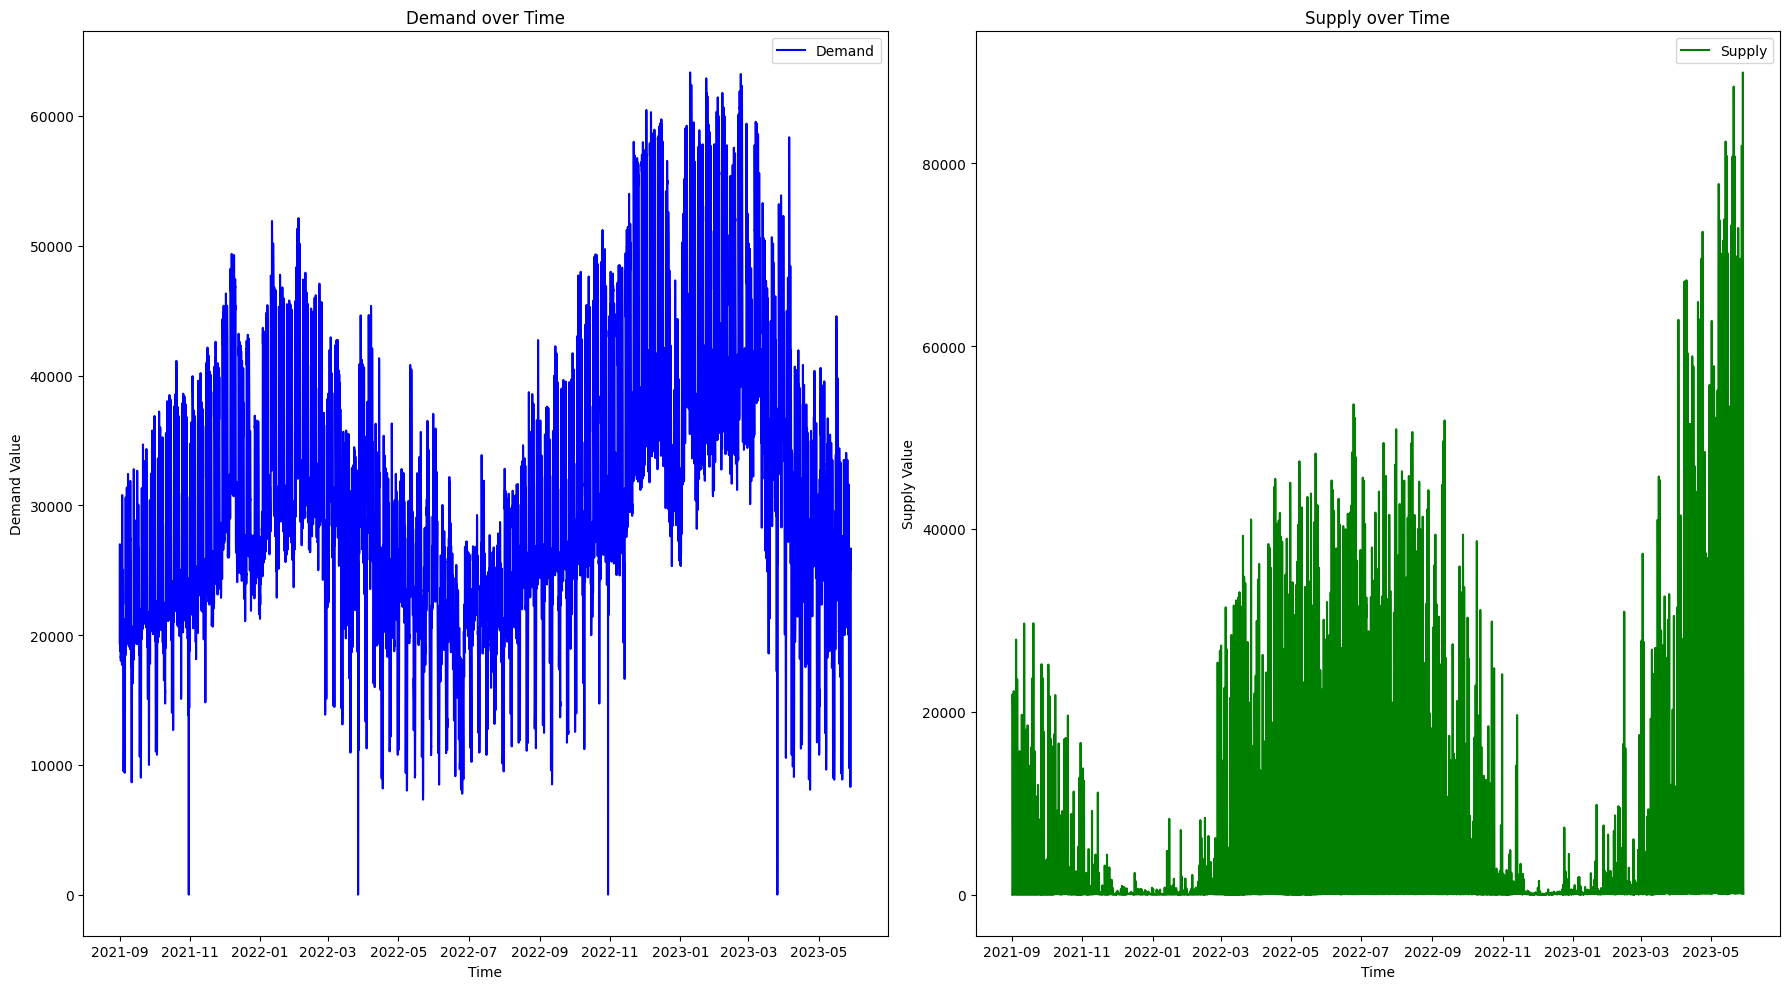

In [13]:
from matplotlib import pyplot as plt
series_demand = final_df['demand']
series_supply = final_df['supply']
series_target = final_df['target']
fig, axs = plt.subplots(1, 2, figsize=(18, 10))  
 
axs[0].plot(series_demand.index, series_demand, label='Demand', linewidth=1.5, color='blue')
axs[0].set_title('Demand over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Demand Value')
axs[0].legend()

axs[1].plot(series_supply.index, series_supply, label='Supply', linewidth=1.5, color='green')
axs[1].set_title('Supply over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Supply Value')
axs[1].legend()

plt.tight_layout()

plt.show()

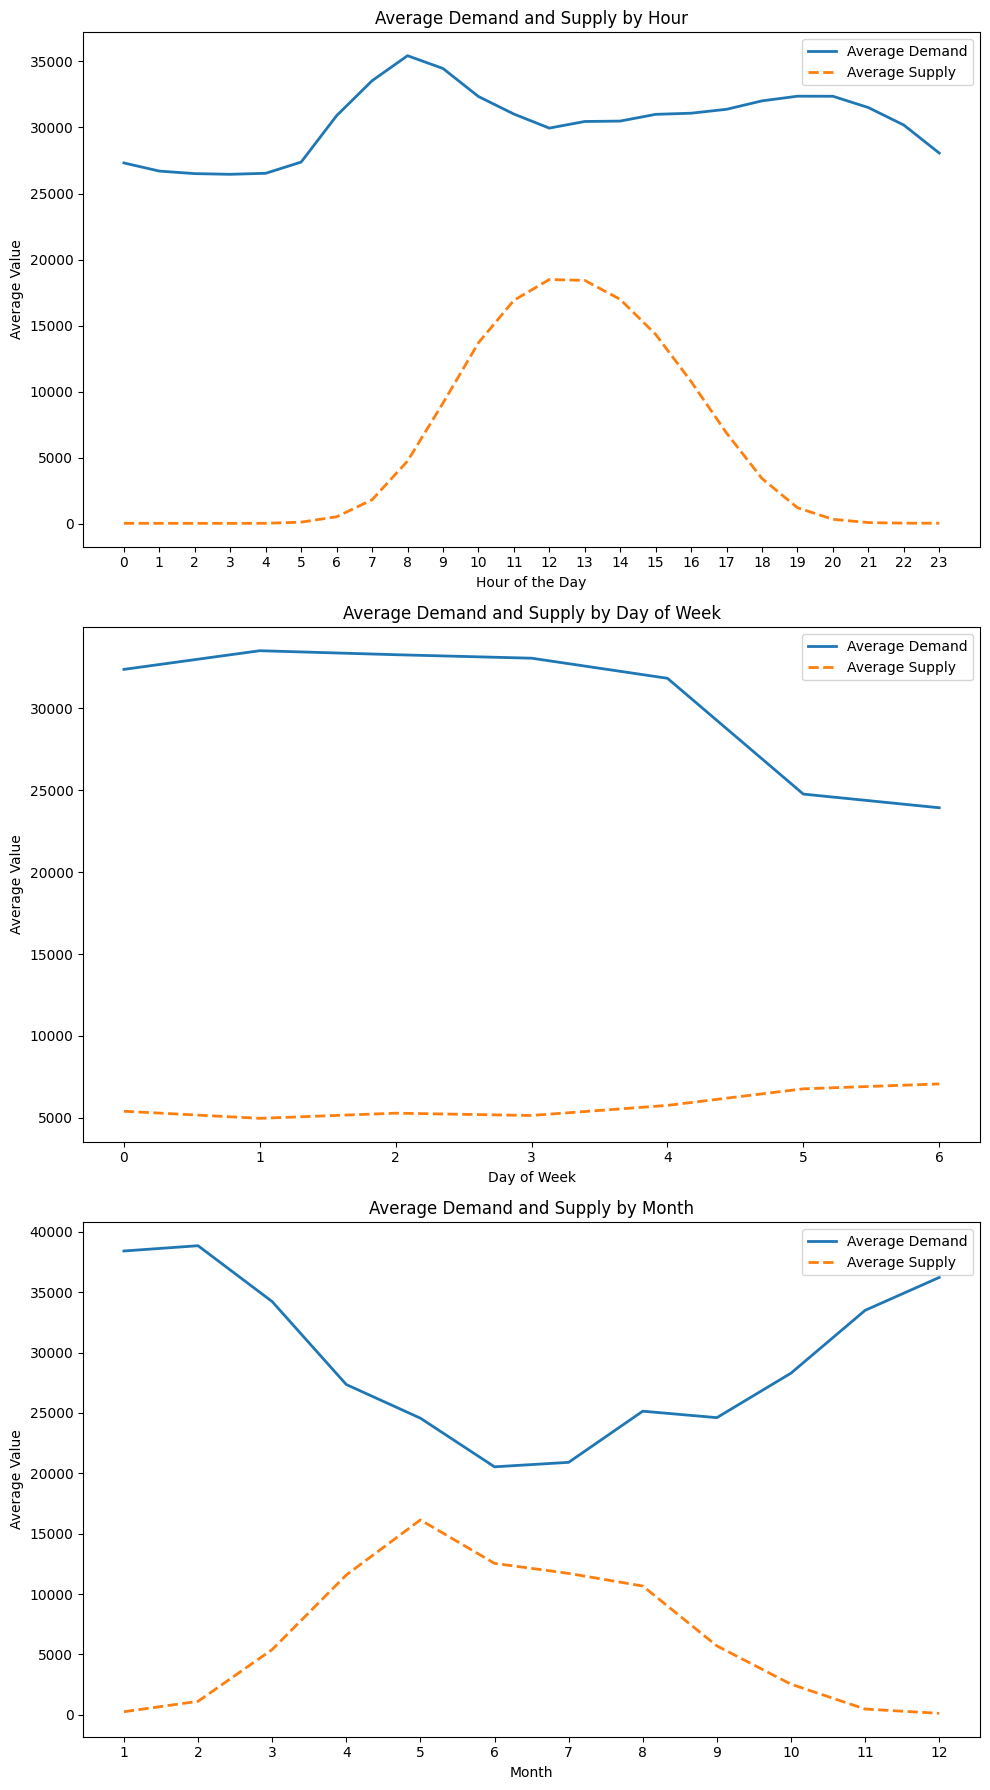

In [117]:
series_demand_hour = final_df['demand'].groupby(final_df.index.hour).mean()
series_supply_hour = final_df['supply'].groupby(final_df.index.hour).mean()

series_demand_dow = final_df['demand'].groupby(final_df.index.dayofweek).mean()
series_supply_dow = final_df['supply'].groupby(final_df.index.dayofweek).mean()

series_demand_month = final_df['demand'].groupby(final_df.index.month).mean()
series_supply_month = final_df['supply'].groupby(final_df.index.month).mean()


plt.figure(figsize=(10, 18))

# by hour
plt.subplot(3, 1, 1)
plt.plot(series_demand_hour.index, series_demand_hour, label='Average Demand', linewidth=2)
plt.plot(series_supply_hour.index, series_supply_hour, label='Average Supply', linewidth=2, linestyle='--')
plt.title('Average Demand and Supply by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Value')
plt.xticks(range(0, 24))
plt.legend()

#  by day of the week
plt.subplot(3, 1, 2)
plt.plot(series_demand_dow.index, series_demand_dow, label='Average Demand', linewidth=2)
plt.plot(series_supply_dow.index, series_supply_dow, label='Average Supply', linewidth=2, linestyle='--')
plt.title('Average Demand and Supply by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Value')
plt.xticks(range(0, 7))
plt.legend()

#  by month
plt.subplot(3, 1, 3)
plt.plot(series_demand_month.index, series_demand_month, label='Average Demand', linewidth=2)
plt.plot(series_supply_month.index, series_supply_month, label='Average Supply', linewidth=2, linestyle='--')
plt.title('Average Demand and Supply by Month')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(range(1, 13))
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


* production peaks midday - and near 0 at night. 
* production peaks in summer, demand drops. due to lesser need for heating during winter.
* production is at its highest during weekends, and consumption drops during weekends. 

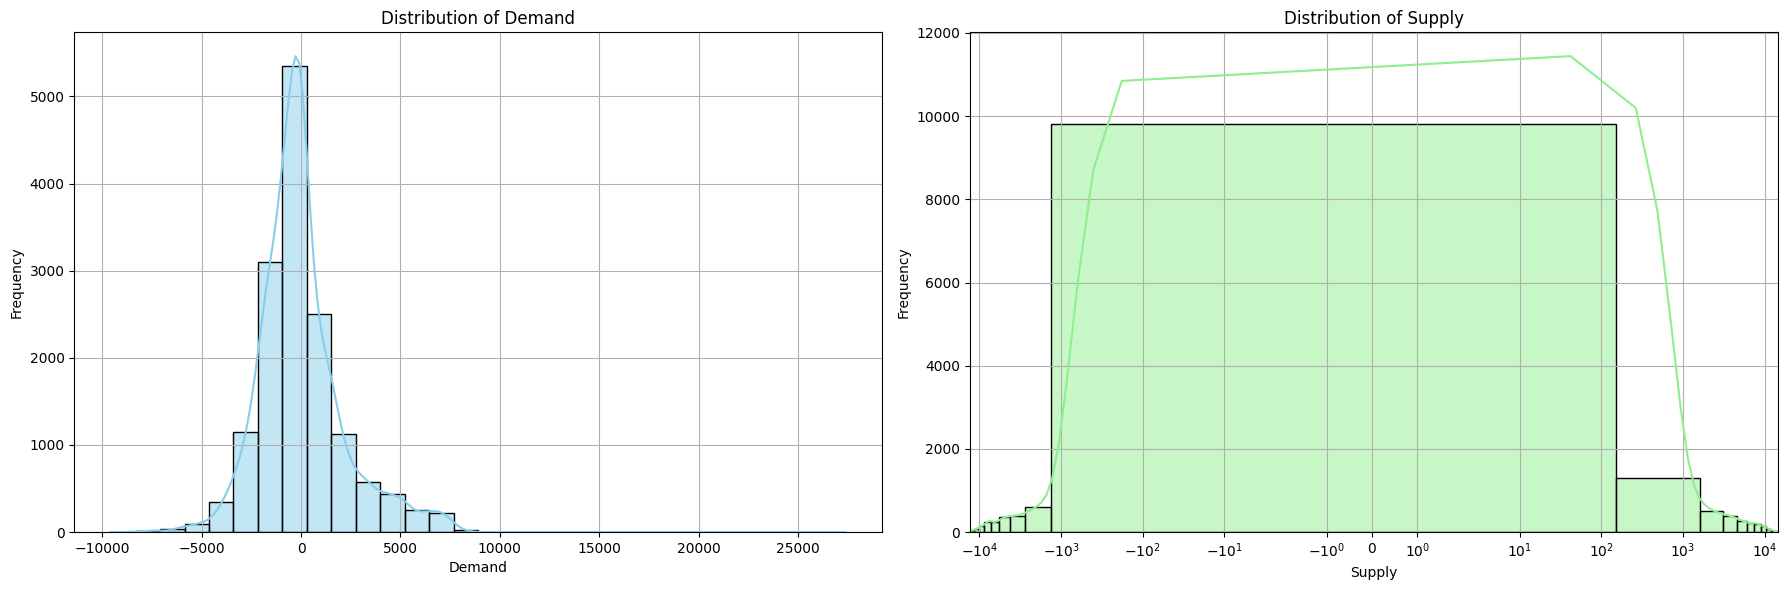

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Plot for Demand
plt.subplot(1, 2, 1)
sns.histplot(final_df['diff_demand'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.grid(True)

# Plot for Supply - Improved visualization
plt.subplot(1, 2, 2)
sns.histplot(final_df['diff_supply'], kde=True, color='lightgreen', bins=30)
plt.title('Distribution of Supply')
plt.xlabel('Supply')
plt.ylabel('Frequency')
plt.grid(True)
plt.xscale('symlog')  # Using symmetrical log scale
plt.xlim(left=final_df['diff_supply'].quantile(0.005), right=final_df['diff_supply'].quantile(0.995))  # Zoom into 1% to 99% quantile range
plt.tight_layout()

# Display the plots
plt.show()


### eda on non target variables - temp, wind .. etc over time
* FFT - Utilizing methods like Fast Fourier Transform (FFT) and Singular Spectrum Analysis (SSA), investigate the underlying periodic patterns for an example user. 
* To uncover potential high-frequency patterns within the dataset that may not be immediately apparent, a Fast Fourier Transform (FFT) analysis is conducted on the first ten unique segments of the dataset. This analysis aims to reveal hidden frequency-based characteristics and periodicities within these segments.





In [17]:
# eda on non target variables - temp, wind .. etc over time
# FFT - Utilizing methods like Fast Fourier Transform (FFT) and Singular Spectrum Analysis (SSA), investigate the underlying periodic patterns for an example user.

# compare FFT on demand and supply vs temp and other variables - if observed periodicity aligns with those of demand/supply, there is significnt correlation between them

In [90]:

periods_in_hours = {
    'Quarterly': (365 / 4) * 24,
    'Monthly': 30 * 24,
    'Weekly': 7 * 24,
    'Daily': 24,
    '12-hour': 12,
    '8-hour': 8,
    '6-hour': 6,
    '4-hour': 4
}
frequencies_for_periods = {k: 1/v for k, v in periods_in_hours.items()}


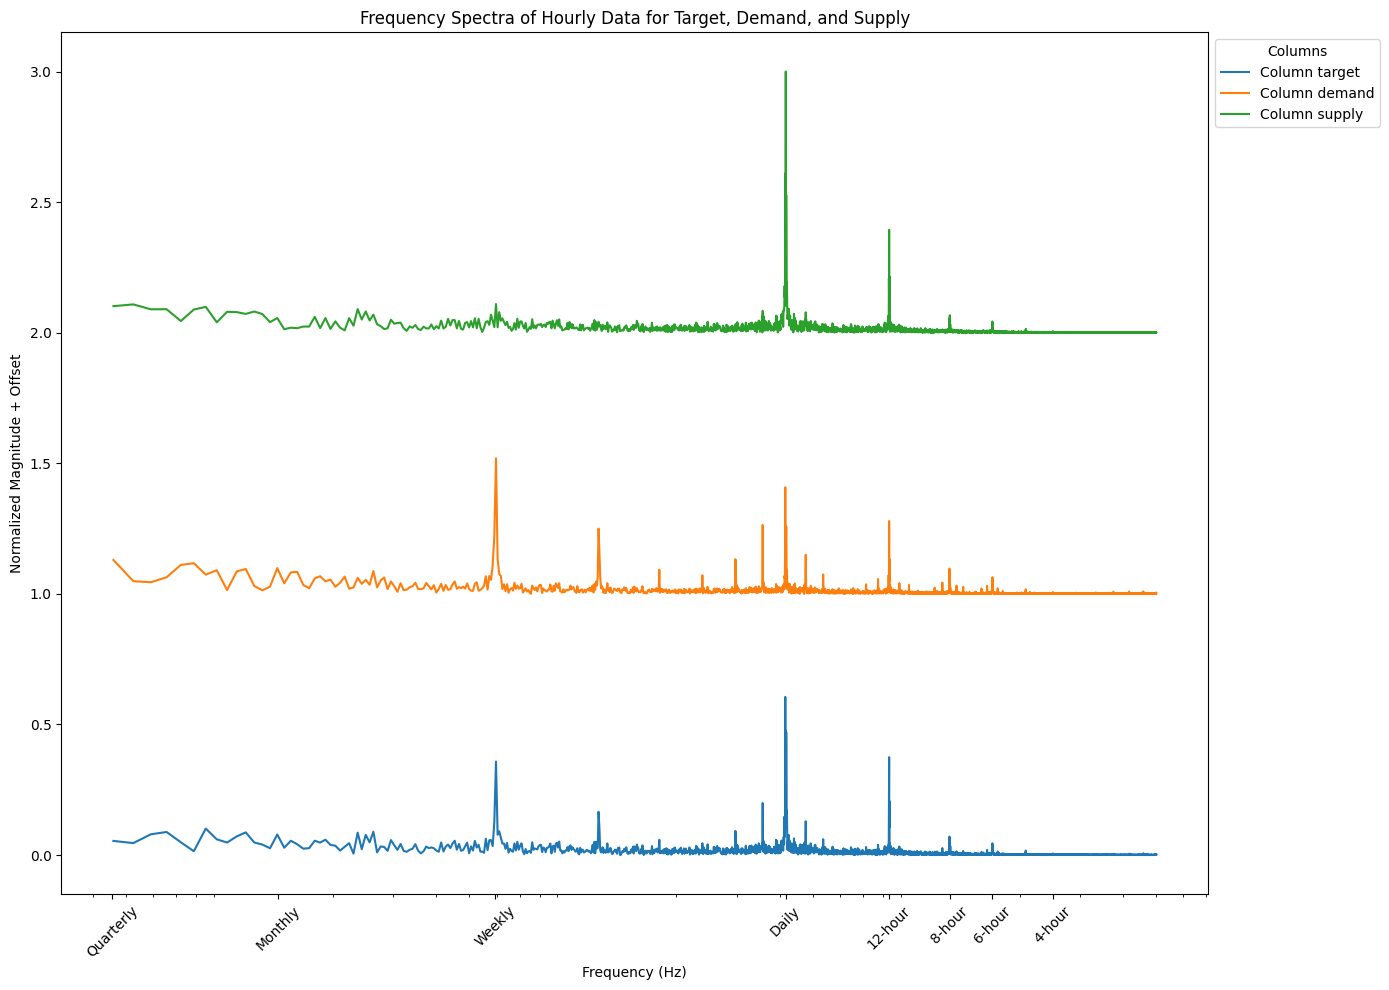

In [91]:
columns_of_interest = ['target', 'demand', 'supply']

plt.figure(figsize=(14, 10))
plt.xscale('log')

for i, column in enumerate(columns_of_interest):
    column_data = final_df[column].dropna()  # Ensure there are no NaN values
    fft_values = np.fft.fft(column_data)
    frequencies = np.fft.fftfreq(len(fft_values), d=1)  # d=1 because data is hourly
    magnitudes = np.abs(fft_values)[frequencies > 0]
    normalized_magnitudes = magnitudes / np.max(magnitudes)
    positive_freqs = frequencies[frequencies > 0]

    # Filter based on the frequencies greater than the 'Quarterly' period
    valid_freqs = positive_freqs[positive_freqs > frequencies_for_periods['Quarterly']]
    valid_magnitudes = normalized_magnitudes[positive_freqs > frequencies_for_periods['Quarterly']]

    offset_magnitudes = valid_magnitudes + i  # Offset for visual clarity

    plt.plot(valid_freqs, offset_magnitudes, label=f'Column {column}')

plt.title('Frequency Spectra of Hourly Data for Target, Demand, and Supply')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude + Offset')
plt.xticks(list(frequencies_for_periods.values()), list(frequencies_for_periods.keys()), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Columns')
plt.tight_layout()
plt.show()

Peaks or spikes in the graph represent dominant frequencies in the data where there are regular patterns or cycles. supply is mainly influenced by daily factors, while demand has more weekly and hourly peaks.

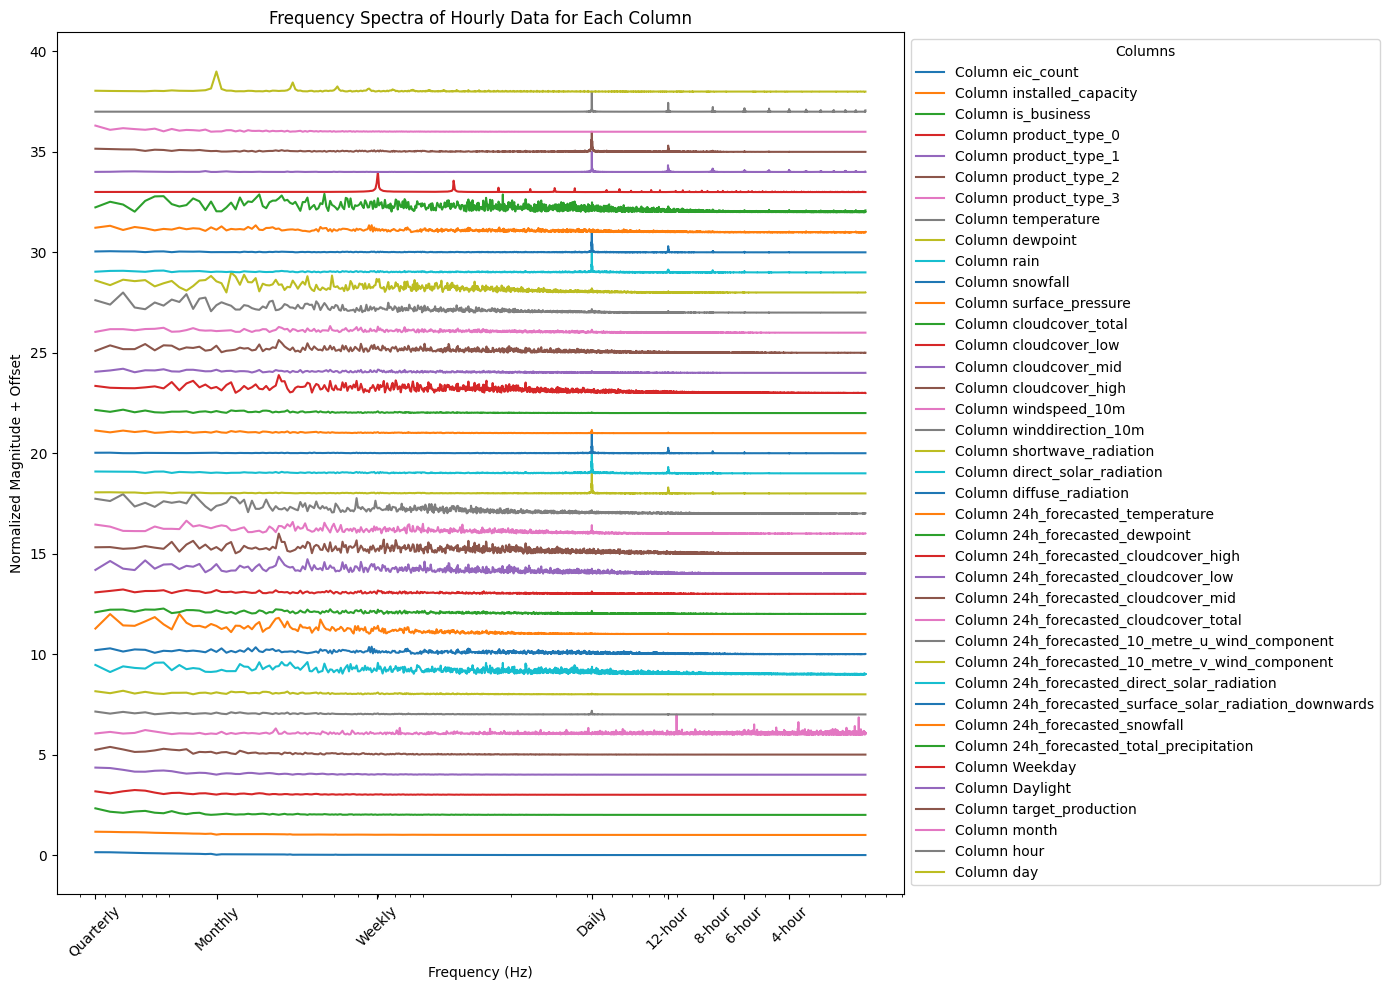

In [96]:

columns_of_interest = final_df.drop(['target', 'supply', 'demand','diff_supply',"diff_demand"], axis=1, errors='ignore').columns 

#columns_of_interest = ['temperature','direct_solar_radiation']

plt.figure(figsize=(14, 10))
plt.xscale('log')

for i, column in enumerate(columns_of_interest):
    column_data = final_df[column].dropna()  # Ensure there are no NaN values
    fft_values = np.fft.fft(column_data)
    frequencies = np.fft.fftfreq(len(fft_values), d=1)  # d=1 because data is hourly
    magnitudes = np.abs(fft_values)[frequencies > 0]
    normalized_magnitudes = magnitudes / np.max(magnitudes)
    positive_freqs = frequencies[frequencies > 0]

    # Adjust the filtering based on updated frequencies for periods
    valid_freqs = positive_freqs[positive_freqs > frequencies_for_periods['Quarterly']]
    valid_magnitudes = normalized_magnitudes[positive_freqs > frequencies_for_periods['Quarterly']]

    offset_magnitudes = valid_magnitudes + i  # Offset for clarity

    plt.plot(valid_freqs, offset_magnitudes, label=f'Column {column}')

plt.title('Frequency Spectra of Hourly Data for Each Column')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude + Offset')
plt.xticks(list(frequencies_for_periods.values()), list(frequencies_for_periods.keys()), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Columns')
plt.tight_layout()
plt.show()


# feature engineering
* **workday vs weekend**
* **day vs night** - whether there is daylight or not = if 0, production should also be 0
* **projected production** 

In [99]:
#create weekday column
def add_weekday_column(df):
    df['Weekday'] = [0 if day > 4 else 1 for day in df.index.dayofweek]
    df['Weekday'] = df['Weekday'].astype('int64')  # Explicitly cast to int64
    return df


#daylight column
def add_daylight_col(df):
    sunset = {1: 15, 2: 17, 3: 18, 4: 20, 5: 21, 6: 22, 7: 22, 8: 21, 9: 19, 10: 18, 11: 15, 12: 15}
    sunrise = {1: 9, 2: 8, 3: 7, 4: 6, 5: 5, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 9}
    
    months = df.index.month
    hours = df.index.hour
    
    daylight_condition = [int(hour >= sunrise[month] and hour < sunset[month]) for hour, month in zip(hours, months)]
    
    df["Daylight"] = daylight_condition
    df['Daylight'] = df['Daylight'].astype('int64')  # Explicitly cast to int64
    return df

#capacity per client
def add_capacity_col(merged_df):
    # Add new feature 'capacity_per_eic'
    merged_df["capacity_per_eic"] = np.round(merged_df["installed_capacity"] / merged_df["eic_count"], 2)
#    merged_df["squared_capacity_client"] = merged_df["installed_capacity"].pow(2)
    #merged_df[["efficiency"]] = merged_df[["target"]][merged_df["installed_capacity_client"].notnull()] / merged_df[["installed_capacity_client"]][merged_df["installed_capacity_client"].notnull()]
    return merged_df

# production - new feature ~ installed_capacity * surface_solar_radiation_downwards / (temperature + 273.15)
# produced power by cells is directly proportional to solar_radiation and inversely to temperature
def add_production_col(df):
    df['target_production'] = df['installed_capacity'] * df['direct_solar_radiation'] / (df['temperature'] + 273.15)
    return df




In [100]:
final_df = add_weekday_column(final_df)
# final_df = add_daylight_col(final_df) - gets dropped
final_df = add_production_col(final_df)
final_df = add_capacity_col(final_df)



In [101]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15235 entries, 2021-09-01 04:00:00 to 2023-05-29 00:00:00
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   target                                            15235 non-null  float64
 1   demand                                            15235 non-null  float64
 2   supply                                            15235 non-null  float64
 3   eic_count                                         15235 non-null  int64  
 4   installed_capacity                                15235 non-null  float64
 5   is_business                                       15235 non-null  int64  
 6   product_type_0                                    15235 non-null  int64  
 7   product_type_1                                    15235 non-null  int64  
 8   product_type_2                                    15235 non-n

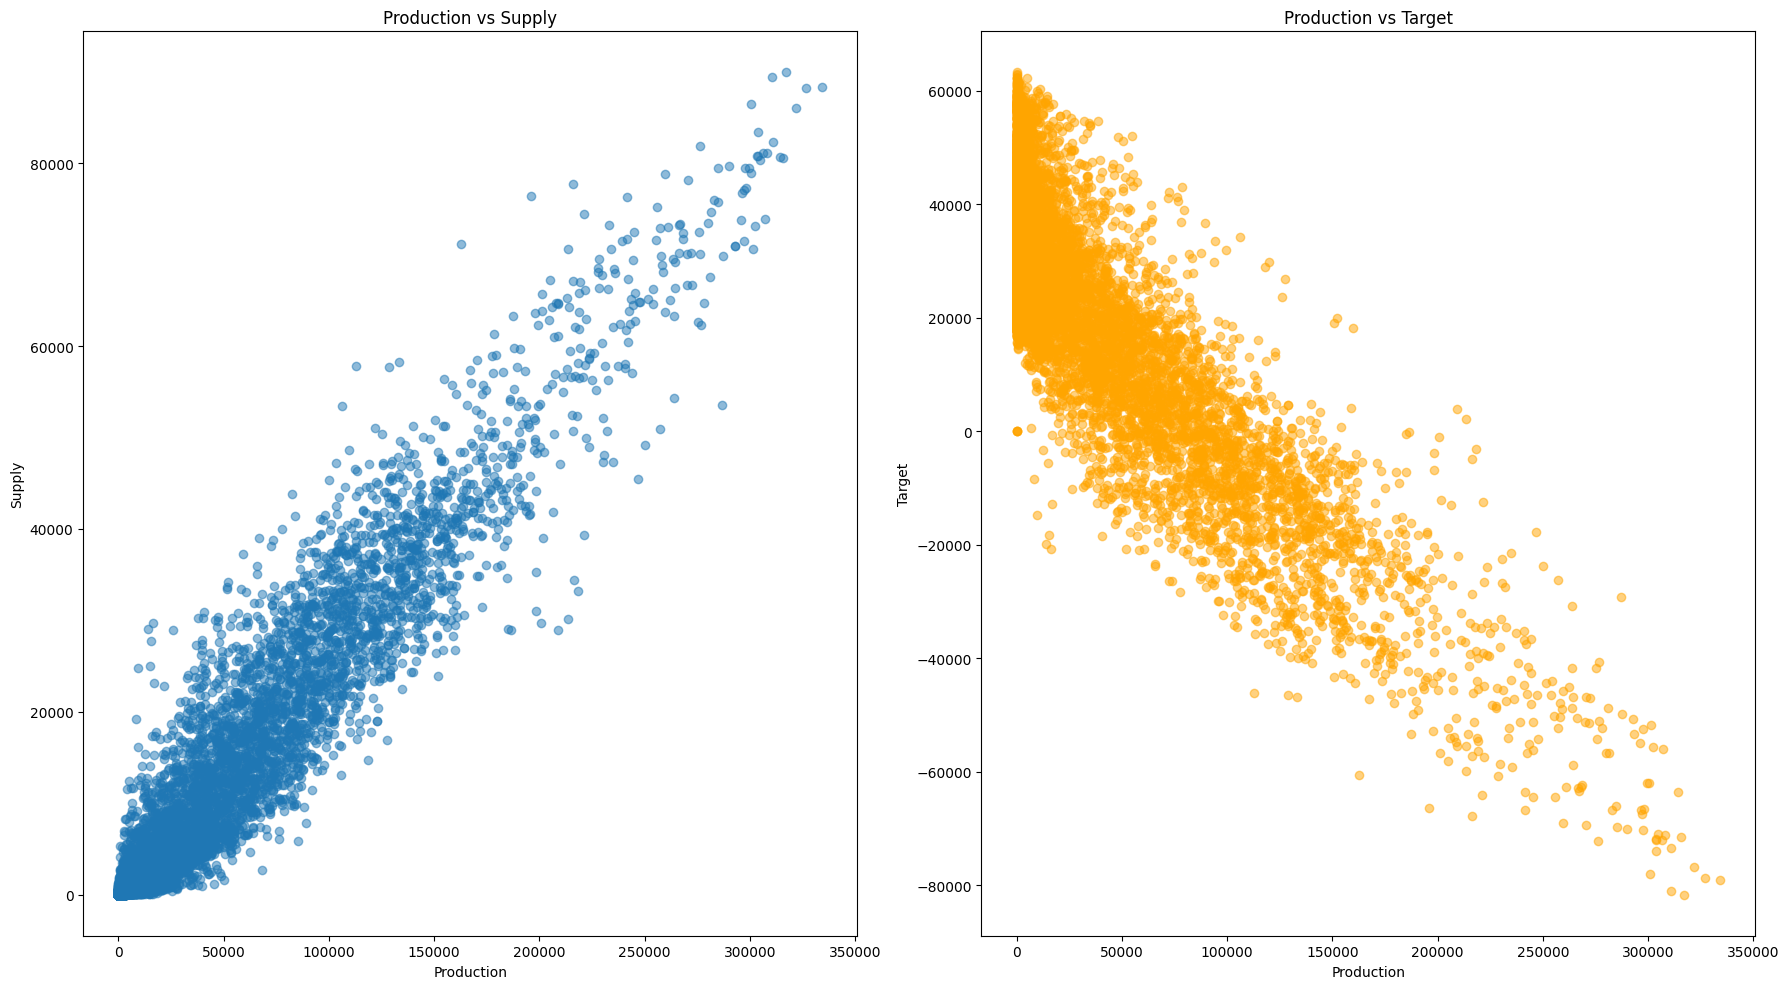

                   target_production    supply
target_production           1.000000  0.964791
supply                      0.964791  1.000000
                   target_production    target
target_production           1.000000 -0.842118
target                     -0.842118  1.000000


In [102]:
series_production = final_df['target_production']
series_supply = final_df['supply']
series_target = final_df['target']

#plot correlation graph of supply and target over production
fig, axs = plt.subplots(1, 2, figsize=(18, 10))

axs[0].scatter(series_production, series_supply, alpha=0.5)
axs[0].set_title('Production vs Supply')
axs[0].set_xlabel('Production')
axs[0].set_ylabel('Supply')

# Scatter plot for Production vs Target
axs[1].scatter(series_production, series_target, alpha=0.5, color='orange')
axs[1].set_title('Production vs Target')
axs[1].set_xlabel('Production')
axs[1].set_ylabel('Target')

plt.tight_layout()
plt.show()

#pearsons correlation for production and supply
correlation = final_df[['target_production', 'supply']].corr(method='pearson')
print(correlation)

#pearsons correlation for production and target
correlation = final_df[['target_production', 'target']].corr(method='pearson')
print(correlation)


# Data Cleaning

In [103]:
# null or 0 values in training data
final_df[final_df['target']==0].head()


,target,demand,supply,eic_count,installed_capacity,is_business,product_type_0,product_type_1,product_type_2,product_type_3,...,24h_forecasted_10_metre_v_wind_component,24h_forecasted_direct_solar_radiation,24h_forecasted_surface_solar_radiation_downwards,24h_forecasted_snowfall,24h_forecasted_total_precipitation,diff_demand,diff_supply,Weekday,target_production,capacity_per_eic
datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-31 03:00:00,0.0,0.0,0.0,3329,74031.460,32,4,24,5,30,...,3.511566,0.0,0.000000,0.000000e+00,1.589518e-06,-19061.726,-14.400,0,7.076856,22.24
2022-03-27 03:00:00,0.0,0.0,0.0,3917,79070.310,37,6,26,5,30,...,1.895281,0.0,0.003492,5.284058e-05,9.117329e-05,-24853.713,-73.235,0,0.000000,20.19
2022-10-30 03:00:00,0.0,0.0,0.0,5435,105136.310,37,6,26,6,30,...,-3.901428,0.0,0.000000,-5.321843e-09,4.406403e-07,-24124.013,-59.488,0,0.000000,19.34
2023-03-26 03:00:00,0.0,0.0,0.0,6419,119424.205,35,6,26,4,30,...,-1.467872,0.0,-0.003175,8.136992e-05,1.447722e-04,-27914.719,-80.644,0,34.695494,18.60


In [104]:
# drop these 4 rows;
final_df = final_df[final_df['target']!=0]

In [105]:
# drop rows - will not affect model
# 24  lowest_price_per_mwh                              15239 non-null  float64
# 25  highest_price_per_mwh                             15239 non-null  float64
# 26  euros_per_mwh  
# year column

final_df = final_df.drop(columns=['lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh'])

In [106]:
final_df['month'] = final_df.index.month
final_df['hour'] = final_df.index.hour
final_df['day'] = final_df.index.day

# xgboost (without feature selection)

In [107]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y

def reformat_predictions_actual(pred, org_X_train):
       '''
       Converts the diff predictions into the original values, returns actual predictions and original values
       y_train[1:,:] + org_y_train[0:-1,:] == org_y_train[1]
       '''
       final_predictions = np.zeros_like(pred)

       for i in range(pred.shape[0]):  # Loop over rows
            final_predictions[i, 0] = org_X_train[i, -1] + pred[i, 0]
            for j in range(1, pred.shape[1]):  # Adjusted to pred's shape for safety
                # Ensure you don't exceed bounds, assuming pred and final_predictions are aligned
                if j < final_predictions.shape[1]:
                    final_predictions[i, j] = final_predictions[i, j-1] + pred[i, j]
                else:
                    break  # Stop if you're about to exceed bounds
       return final_predictions

In [108]:
df = final_df.copy()

In [109]:
from sklearn.preprocessing import MinMaxScaler

n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.drop(columns=['target', 'supply', 'diff_supply', 'demand']).columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

# for xgboost - 
X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,365, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,365, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,365, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12112, 48, 40), y shape: (12112, 24)
X shape: (1452, 48, 40), y shape: (1452, 24)
X shape: (1453, 48, 40), y shape: (1453, 24)
X shape: (12112, 48, 40), y shape: (12112, 24)
X shape: (1452, 48, 40), y shape: (1452, 24)
X shape: (1453, 48, 40), y shape: (1453, 24)
X shape: (11795, 365), y shape: (11795, 24)
X shape: (1135, 365), y shape: (1135, 24)
X shape: (1136, 365), y shape: (1136, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [110]:
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [111]:
#xgbmodel = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, early_stopping_rounds=10, eta=0.1)
#quick runtime test
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=2,
    n_estimators=50,  
    learning_rate=0.1,
    verbosity=0
)

xgbmodel.fit(X_train_flat, y_train, eval_set=[(X_train_flat, y_train), (X_val_flat, y_val)])


[0]	validation_0-rmse:1951.52614	validation_1-rmse:2581.88011
[1]	validation_0-rmse:1864.67944	validation_1-rmse:2475.07531
[2]	validation_0-rmse:1790.60380	validation_1-rmse:2380.15676
[3]	validation_0-rmse:1725.60809	validation_1-rmse:2298.69607
[4]	validation_0-rmse:1670.49605	validation_1-rmse:2221.54390
[5]	validation_0-rmse:1622.25532	validation_1-rmse:2157.70135
[6]	validation_0-rmse:1576.59229	validation_1-rmse:2100.62695
[7]	validation_0-rmse:1535.44230	validation_1-rmse:2049.04751
[8]	validation_0-rmse:1500.96102	validation_1-rmse:2003.66563
[9]	validation_0-rmse:1473.11242	validation_1-rmse:1963.06591
[10]	validation_0-rmse:1441.98454	validation_1-rmse:1926.98762
[11]	validation_0-rmse:1419.85671	validation_1-rmse:1897.16777
[12]	validation_0-rmse:1395.99528	validation_1-rmse:1867.97817
[13]	validation_0-rmse:1376.26053	validation_1-rmse:1840.10444
[14]	validation_0-rmse:1357.04044	validation_1-rmse:1813.87205
[15]	validation_0-rmse:1341.81849	validation_1-rmse:1794.20313
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

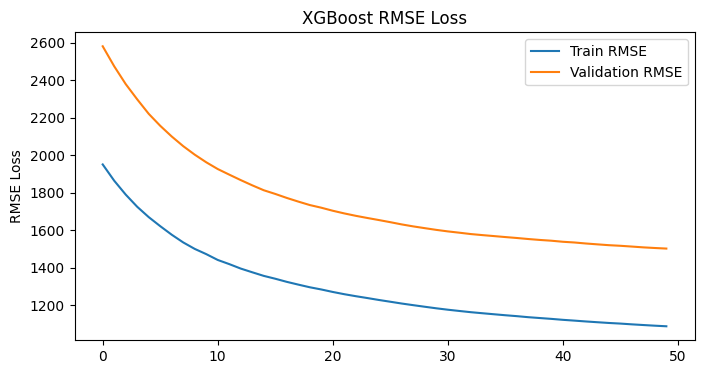

In [112]:
results = xgbmodel.evals_result()
train_mae, val_mae = results["validation_0"]["rmse"], results["validation_1"]["rmse"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train RMSE")
ax.plot(x_values, val_mae, label="Validation RMSE")
ax.legend()
plt.ylabel("RMSE Loss")
plt.title("XGBoost RMSE Loss")
plt.show()

In [113]:
train_pred = xgbmodel.predict(X_train_flat)
val_pred = xgbmodel.predict(X_val_flat)
test_pred = xgbmodel.predict(X_test_flat)

xg_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
xg_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
xg_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

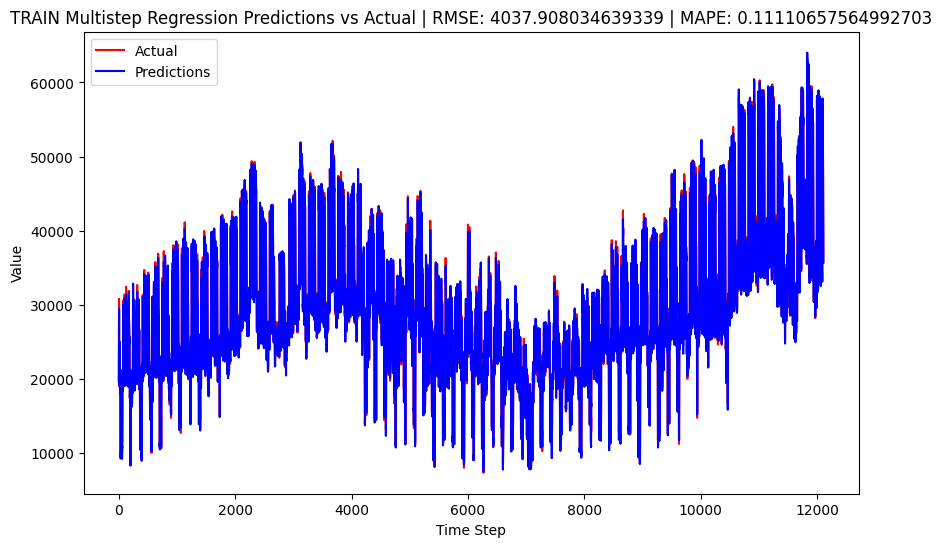

In [114]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(xg_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, xg_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, xg_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Feature Selection

* drop rows w no contextual importance
* RFE feature selection with xgboost estimator 
* RFE feature selection with random forest predictive model

Selected Features:
installed_capacity
dewpoint
rain
surface_pressure
cloudcover_total
cloudcover_low
cloudcover_mid
shortwave_radiation
direct_solar_radiation
diffuse_radiation
24h_forecasted_temperature
24h_forecasted_cloudcover_low
24h_forecasted_10_metre_u_wind_component
24h_forecasted_10_metre_v_wind_component
24h_forecasted_direct_solar_radiation
24h_forecasted_surface_solar_radiation_downwards
Weekday
target_production
capacity_per_eic
hour


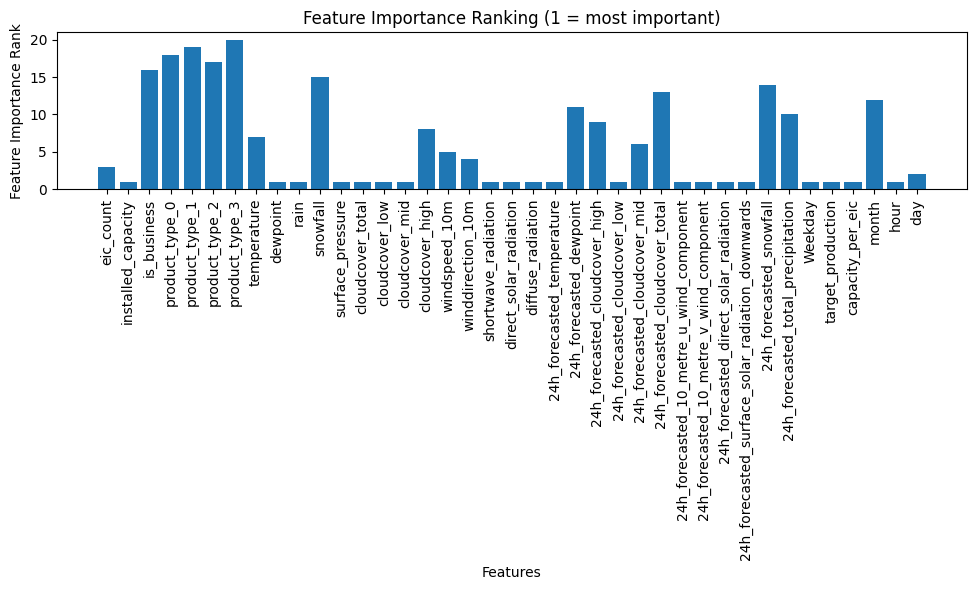

In [116]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

feat_sel_df = final_df.copy()
feat_sel_df['month'] = feat_sel_df.index.month
feat_sel_df['day'] = feat_sel_df.index.day
feat_sel_df['hour'] = feat_sel_df.index.hour

feat_sel_df = feat_sel_df.dropna()

train_y = feat_sel_df['diff_demand']
train_X = feat_sel_df.drop(["target", "supply", "demand","diff_demand","diff_supply"], axis=1)


rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=20)
fit = rfe.fit(train_X, train_y)

print('Selected Features:')
names = train_X.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

plt.figure(figsize=(10, 6))
plt.bar(range(train_X.shape[1]), fit.ranking_)
plt.xticks(range(train_X.shape[1]), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Rank')
plt.title('Feature Importance Ranking (1 = most important)')
plt.tight_layout()  
plt.show()


In [123]:
print('Dropped Features:')
dropped_features = train_X.columns.values[~fit.support_]
print(dropped_features)

Dropped Features:
['eic_count' 'is_business' 'product_type_0' 'product_type_1'
 'product_type_2' 'product_type_3' 'temperature' 'snowfall'
 'cloudcover_high' 'windspeed_10m' 'winddirection_10m'
 '24h_forecasted_dewpoint' '24h_forecasted_cloudcover_high'
 '24h_forecasted_cloudcover_mid' '24h_forecasted_cloudcover_total'
 '24h_forecasted_snowfall' '24h_forecasted_total_precipitation' 'month'
 'day']


In [131]:
selected_features = train_X.columns[fit.support_]

filtered_df = final_df[list(selected_features) + ['diff_demand'] + ['demand']]

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15231 entries, 2021-09-01 04:00:00 to 2023-05-29 00:00:00
Data columns (total 22 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   installed_capacity                                15231 non-null  float64
 1   dewpoint                                          15231 non-null  float64
 2   rain                                              15231 non-null  float64
 3   surface_pressure                                  15231 non-null  float64
 4   cloudcover_total                                  15231 non-null  float64
 5   cloudcover_low                                    15231 non-null  float64
 6   cloudcover_mid                                    15231 non-null  float64
 7   shortwave_radiation                               15231 non-null  float64
 8   direct_solar_radiation                            15231 non-n

In [132]:
df = filtered_df.copy()
n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

# for xgboost - 
X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [133]:
X_train_flat1 = X_train.reshape(X_train.shape[0], -1)  
X_val_flat1 = X_val.reshape(X_val.shape[0], -1)
X_test_flat1 = X_test.reshape(X_test.shape[0], -1)

In [134]:
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=2,
    n_estimators=50,  
    learning_rate=0.1,
    verbosity=0
)

xgbmodel.fit(X_train_flat1, y_train, eval_set=[(X_train_flat1, y_train), (X_val_flat1, y_val)])


[0]	validation_0-rmse:1951.52614	validation_1-rmse:2581.88011
[1]	validation_0-rmse:1864.67944	validation_1-rmse:2475.07531
[2]	validation_0-rmse:1790.60380	validation_1-rmse:2380.15676
[3]	validation_0-rmse:1725.60373	validation_1-rmse:2298.60461
[4]	validation_0-rmse:1670.45156	validation_1-rmse:2221.41085
[5]	validation_0-rmse:1622.18743	validation_1-rmse:2157.58463
[6]	validation_0-rmse:1576.52860	validation_1-rmse:2100.55014
[7]	validation_0-rmse:1535.28633	validation_1-rmse:2049.09274
[8]	validation_0-rmse:1500.85469	validation_1-rmse:2003.76134
[9]	validation_0-rmse:1473.05229	validation_1-rmse:1963.11603
[10]	validation_0-rmse:1441.83906	validation_1-rmse:1926.40261
[11]	validation_0-rmse:1419.69551	validation_1-rmse:1896.83774
[12]	validation_0-rmse:1395.70436	validation_1-rmse:1867.82933
[13]	validation_0-rmse:1375.93610	validation_1-rmse:1840.03917
[14]	validation_0-rmse:1356.72850	validation_1-rmse:1813.38544
[15]	validation_0-rmse:1341.52030	validation_1-rmse:1793.25768
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

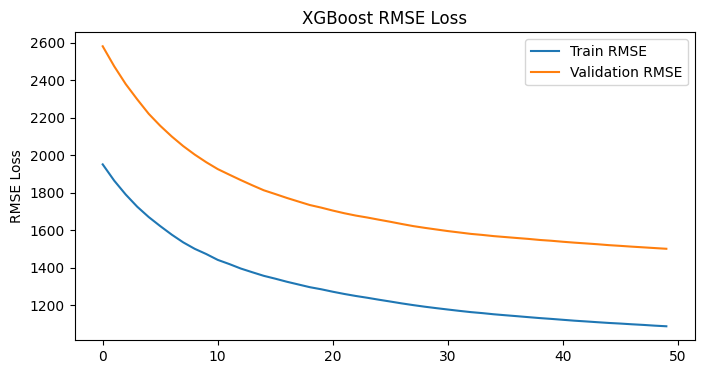

In [135]:
results = xgbmodel.evals_result()
train_mae, val_mae = results["validation_0"]["rmse"], results["validation_1"]["rmse"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train RMSE")
ax.plot(x_values, val_mae, label="Validation RMSE")
ax.legend()
plt.ylabel("RMSE Loss")
plt.title("XGBoost RMSE Loss")
plt.show()

In [136]:
train_pred = xgbmodel.predict(X_train_flat1)
val_pred = xgbmodel.predict(X_val_flat1)
test_pred = xgbmodel.predict(X_test_flat1)

xg_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
xg_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
xg_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

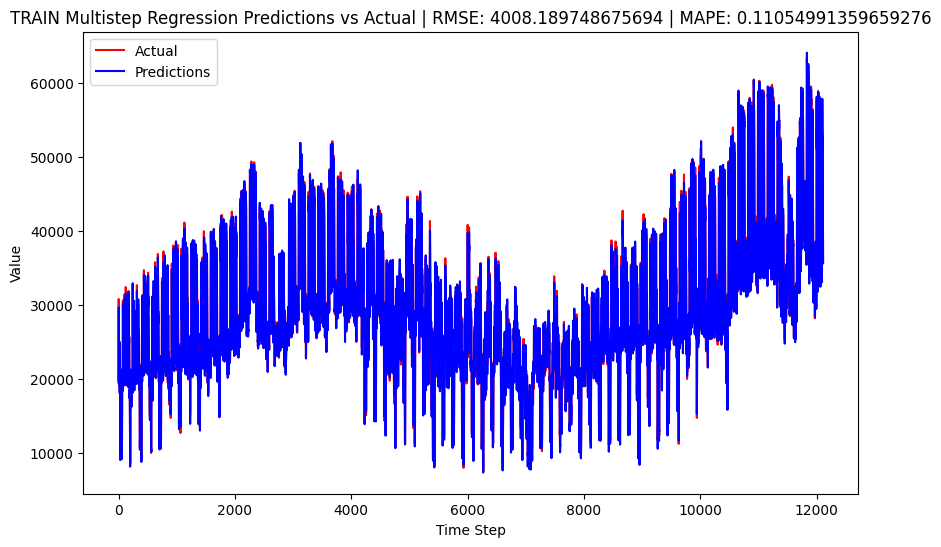

In [137]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(xg_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, xg_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, xg_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# CNN testing difference 

In [138]:

import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


In [139]:
# non feature selected dataset
df = final_df.copy()

n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.drop(columns=['target', 'supply', 'diff_supply', 'demand']).columns

dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12112, 48, 40), y shape: (12112, 24)
X shape: (1452, 48, 40), y shape: (1452, 24)
X shape: (1453, 48, 40), y shape: (1453, 24)
X shape: (12112, 48, 40), y shape: (12112, 24)
X shape: (1452, 48, 40), y shape: (1452, 24)
X shape: (1453, 48, 40), y shape: (1453, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [140]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

2024-03-17 01:00:55.986104: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-17 01:00:55.986135: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-17 01:00:55.986144: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-17 01:00:55.986850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 01:00:55.987258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 64)            7744      
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 16)             1552      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 16)             0

In [141]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=10, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/10


2024-03-17 01:01:00.107326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 151s 774ms/step - loss: 0.0218 - val_loss: 0.0066
Epoch 2/10
190/190 [==============================] - 150s 790ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 3/10
190/190 [==============================] - 147s 771ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 4/10
190/190 [==============================] - 149s 783ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 5/10
190/190 [==============================] - 150s 790ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 6/10
190/190 [==============================] - 139s 733ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 7/10
190/190 [==============================] - 135s 709ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 8/10
190/190 [==============================] - 377s 2s/step - loss: 0.0030 - val_loss: 0.0050
Epoch 9/10
190/190 [==============================] - 1035s 5s/step - loss: 0.0028 - val_loss: 0.0047
Epoch 10/10
190/190 [==============================] - 73s 382ms/step - loss: 0.

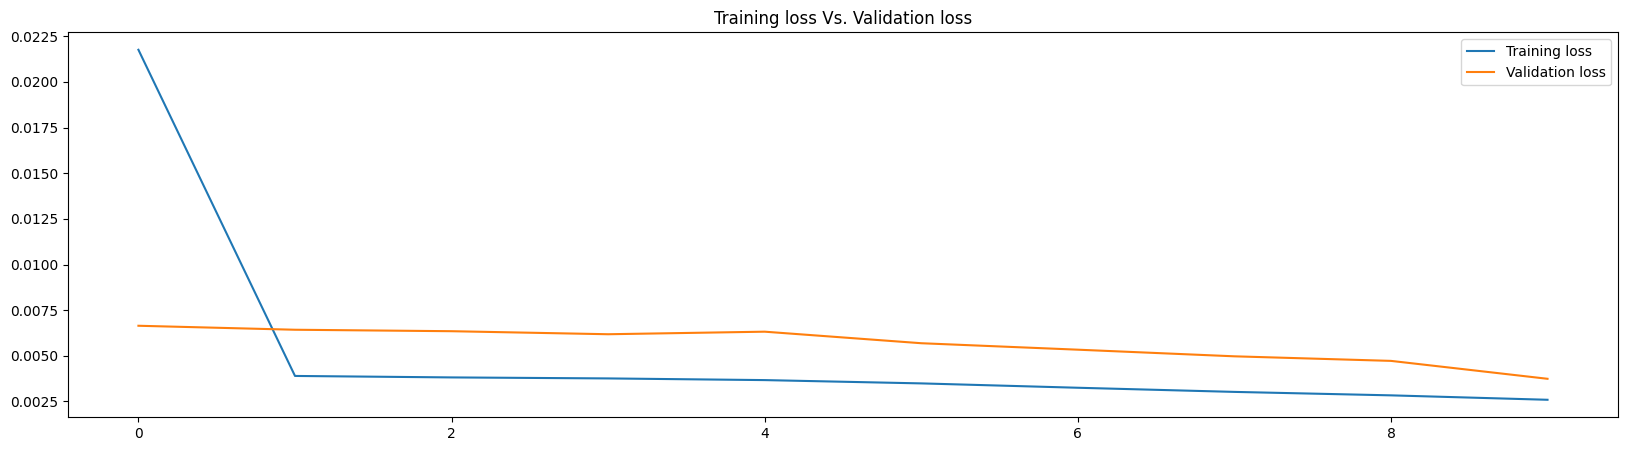

In [142]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [143]:
nn_y_train_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape)), org_X_train)
nn_y_val_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape)), org_X_val)
nn_y_test_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape)), org_X_test)

46/46 [==============================] - 10s 227ms/step


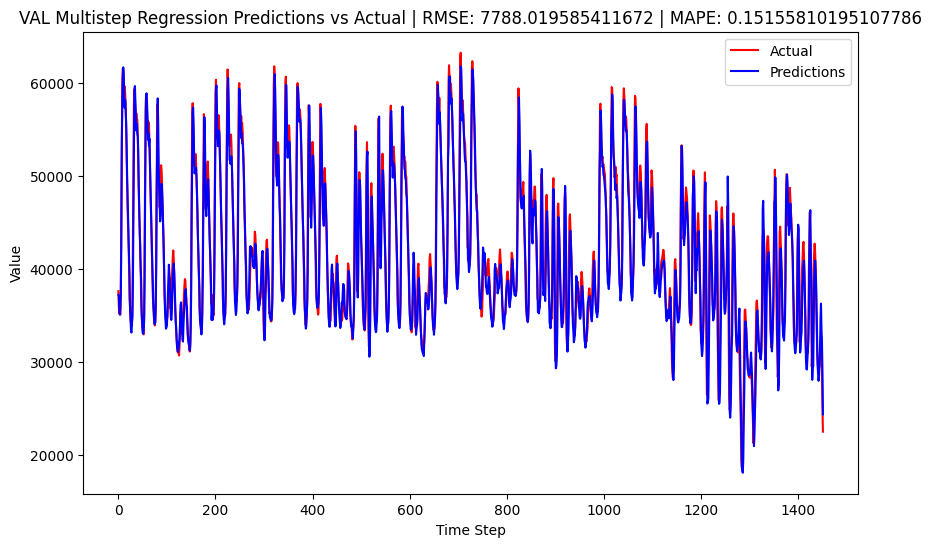

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(nn_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, nn_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, nn_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# CNN with feature selection 

In [145]:
filtered_df

,installed_capacity,dewpoint,rain,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,shortwave_radiation,direct_solar_radiation,diffuse_radiation,...,24h_forecasted_10_metre_u_wind_component,24h_forecasted_10_metre_v_wind_component,24h_forecasted_direct_solar_radiation,24h_forecasted_surface_solar_radiation_downwards,Weekday,target_production,capacity_per_eic,hour,diff_demand,demand
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 04:00:00,70659.260,10.410714,0.0,1008.670536,29.973214,26.767857,3.178571,0.000000,0.000000,0.000000,...,2.222443,-5.779210,0.000000,-0.004127,1,0.000000,22.37,4,340.640,19367.124
2021-09-01 05:00:00,70659.260,10.212500,0.0,1008.514286,26.285714,22.883929,2.946429,0.000000,0.000000,0.000000,...,2.423018,-5.667920,0.000000,0.000000,1,0.000000,22.37,5,1275.225,20642.349
2021-09-01 06:00:00,70659.260,10.075000,0.0,1008.213393,29.026786,23.339286,4.107143,9.982143,3.196429,6.785714,...,2.579115,-5.559556,60.108987,8.876303,1,790.535057,22.37,6,3454.273,24096.622
2021-09-01 07:00:00,70659.260,10.168750,0.0,1008.350000,27.767857,19.044643,6.910714,80.107143,38.607143,41.500000,...,2.711851,-5.481456,298.963446,82.869551,1,9531.717947,22.37,7,2469.043,26565.665
2021-09-01 08:00:00,70659.260,10.025893,0.0,1008.260714,32.187500,22.446429,8.035714,186.401786,109.491071,76.910714,...,2.943281,-5.701183,482.992128,196.049614,1,26973.095385,22.37,8,432.682,26998.347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-28 20:00:00,148058.705,6.007143,0.0,1011.966071,33.625000,16.875000,32.080357,86.982143,42.875000,44.107143,...,2.508707,-1.642133,320.360933,105.980952,0,22081.979222,19.87,20,2779.113,23967.127
2023-05-28 21:00:00,148058.705,6.326786,0.0,1011.901786,21.491071,12.419643,18.196429,19.964286,7.464286,12.500000,...,2.269524,-1.335344,111.688056,25.386349,0,3861.637830,19.87,21,1818.251,25785.378
2023-05-28 22:00:00,148058.705,6.600893,0.0,1011.999107,23.205357,13.401786,19.758929,0.107143,0.000000,0.107143,...,2.185002,-1.022191,1.546032,0.245397,0,0.000000,19.87,22,885.411,26670.789


In [147]:
df = filtered_df.copy()
n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')


X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [148]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 46, 64)            4288      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 16)             1552      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 16)            

In [149]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=10, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/10
190/190 [==============================] - 75s 383ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 2/10
190/190 [==============================] - 85s 446ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 3/10
190/190 [==============================] - 173s 912ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 4/10
190/190 [==============================] - 324s 2s/step - loss: 0.0024 - val_loss: 0.0034
Epoch 5/10
190/190 [==============================] - 1957s 10s/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/10
190/190 [==============================] - 72s 376ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 7/10
190/190 [==============================] - 1449s 8s/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/10
190/190 [==============================] - 1096s 6s/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/10
190/190 [==============================] - 991s 5s/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/10
190/190 [==============================] - 1203s 6s/step - loss: 0

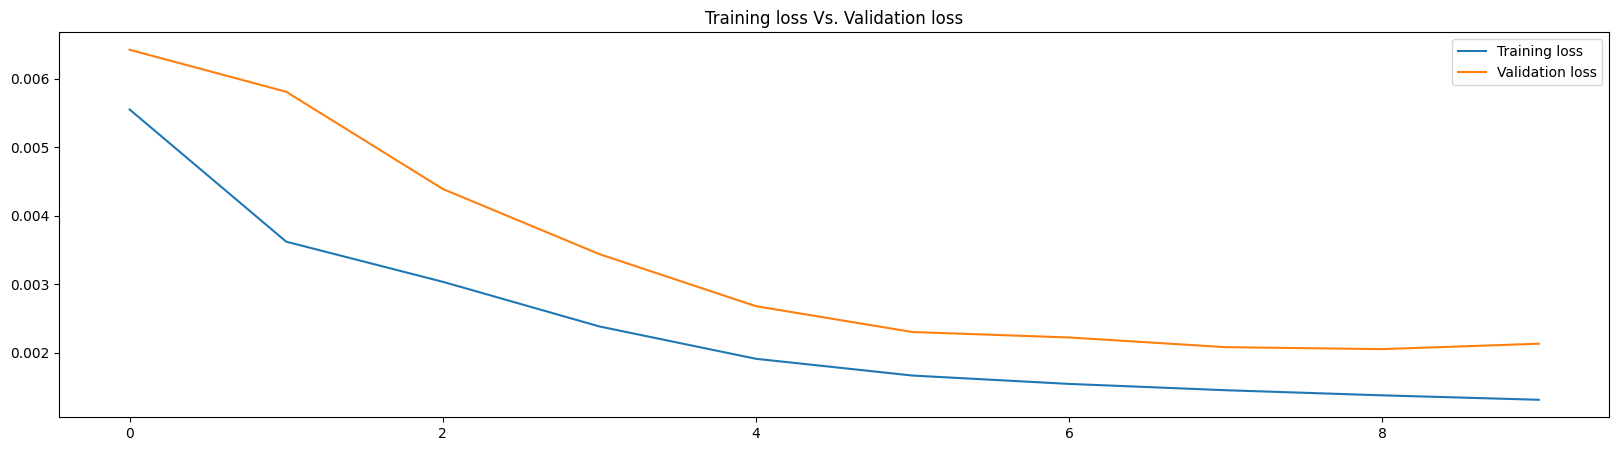

In [150]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [151]:
nn_y_train_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape)), org_X_train)
nn_y_val_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape)), org_X_val)
nn_y_test_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape)), org_X_test)

46/46 [==============================] - 9s 194ms/step


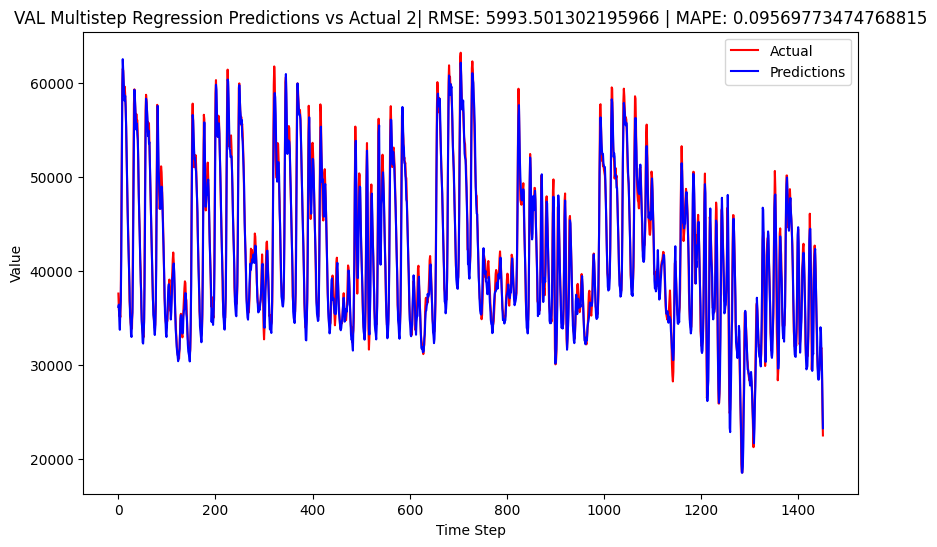

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(nn_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual 2| RMSE: {np.sqrt(mean_squared_error(org_y_val, nn_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, xg_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

feat_sel_df = final_df.copy()
feat_sel_df['month'] = feat_sel_df.index.month
feat_sel_df['day'] = feat_sel_df.index.day
feat_sel_df['weekday'] = feat_sel_df.index.weekday
feat_sel_df['hour'] = feat_sel_df.index.hour

feat_sel_df = feat_sel_df.dropna()

train_y = feat_sel_df['demand']
train_X = feat_sel_df.drop(["target", "supply", "demand"], axis=1)


rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=30)
fit = rfe.fit(train_X, train_y)

print('Selected Features:')
names = train_X.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

plt.figure(figsize=(10, 6))
plt.bar(range(train_X.shape[1]), fit.ranking_)
plt.xticks(range(train_X.shape[1]), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Rank')
plt.title('Feature Importance Ranking (1 = most important)')
plt.tight_layout()  
plt.show()


KeyboardInterrupt: 

In [199]:
final_df.head()

,target,demand,supply,eic_count,installed_capacity,is_business,product_type_0,product_type_1,product_type_2,product_type_3,...,24h_forecasted_10_metre_v_wind_component,24h_forecasted_direct_solar_radiation,24h_forecasted_surface_solar_radiation_downwards,24h_forecasted_snowfall,24h_forecasted_total_precipitation,diff_demand,diff_supply,Weekday,Daylight,target_production
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 04:00:00,19364.632,19367.124,2.492,3159,70659.26,31,4,22,5,30,...,-5.779210,0.000000,-0.004127,0.0,0.000049,340.640,0.975,1,0,0.000000
2021-09-01 05:00:00,20633.672,20642.349,8.677,3159,70659.26,31,4,22,5,30,...,-5.667920,0.000000,0.000000,0.0,0.000038,1275.225,6.185,1,0,0.000000
2021-09-01 06:00:00,24024.469,24096.622,72.153,3159,70659.26,31,4,22,5,30,...,-5.559556,60.108987,8.876303,0.0,0.000028,3454.273,63.476,1,0,790.535057
2021-09-01 07:00:00,25422.473,26565.665,1143.192,3159,70659.26,31,4,22,5,30,...,-5.481456,298.963446,82.869551,0.0,0.000024,2469.043,1071.039,1,1,9531.717947
2021-09-01 08:00:00,22332.792,26998.347,4665.555,3159,70659.26,31,4,22,5,30,...,-5.701183,482.992128,196.049614,0.0,0.000024,432.682,3522.363,1,1,26973.095385


In [ ]:
feat_sel_df = final_df.copy()

feat_sel_df['year'] = feat_sel_df.index.year
feat_sel_df['month'] = feat_sel_df.index.month
feat_sel_df['day'] = feat_sel_df.index.day
feat_sel_df['weekday'] = feat_sel_df.index.weekday
feat_sel_df['hour'] = feat_sel_df.index.hour

feat_sel_df = feat_sel_df.dropna()

train_y = feat_sel_df['demand']
train_X = feat_sel_df.drop(["target", "supply", "demand"], axis=1)

In [85]:
feat_sel_df = final_df.copy()

# Extract datetime components directly from the DatetimeIndex
feat_sel_df['year'] = feat_sel_df.index.year
feat_sel_df['month'] = feat_sel_df.index.month
feat_sel_df['day'] = feat_sel_df.index.day
feat_sel_df['weekday'] = feat_sel_df.index.weekday
feat_sel_df['hour'] = feat_sel_df.index.hour
feat_sel_df.info()

# Drop rows with NaN values
feat_sel_df = feat_sel_df.dropna()
feat_sel_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15235 entries, 2021-09-01 00:00:00 to 2023-05-29 00:00:00
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   target                                            15235 non-null  float64
 1   demand                                            15235 non-null  float64
 2   supply                                            15235 non-null  float64
 3   eic_count                                         15235 non-null  int64  
 4   installed_capacity                                15235 non-null  float64
 5   is_business                                       15235 non-null  int64  
 6   product_type_0                                    15235 non-null  uint8  
 7   product_type_1                                    15235 non-null  uint8  
 8   product_type_2                                    15235 non-n

In [86]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification


feat_sel_df = final_df.copy()

feat_sel_df['year'] = feat_sel_df.index.year
feat_sel_df['month'] = feat_sel_df.index.month
feat_sel_df['day'] = feat_sel_df.index.day
feat_sel_df['weekday'] = feat_sel_df.index.weekday
feat_sel_df['hour'] = feat_sel_df.index.hour

feat_sel_df = feat_sel_df.dropna()
feat_sel_df.info()

X = feat_sel_df.drop(['demand'], axis=1)  
y = feat_sel_df['demand']

rfe = LinearRegression()
rfe = RFE(estimator = rfe, n_features_to_select=40, step=1)
rfe= rfe.fit(X,y)

ranking = rfe.ranking_

selected_features = rfe.support_

feature_names = X.columns
dropped_features = feature_names[~selected_features]
print("Dropped Features: ", dropped_features)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15232 entries, 2021-09-01 03:00:00 to 2023-05-29 00:00:00
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   target                                            15232 non-null  float64
 1   demand                                            15232 non-null  float64
 2   supply                                            15232 non-null  float64
 3   eic_count                                         15232 non-null  int64  
 4   installed_capacity                                15232 non-null  float64
 5   is_business                                       15232 non-null  int64  
 6   product_type_0                                    15232 non-null  uint8  
 7   product_type_1                                    15232 non-null  uint8  
 8   product_type_2                                    15232 non-n

In [87]:
#feature selection by correlation 


from sklearn import preprocessing


feat_sel_df = final_df.copy()

feat_sel_df['year'] = feat_sel_df.index.year
feat_sel_df['month'] = feat_sel_df.index.month
feat_sel_df['day'] = feat_sel_df.index.day
feat_sel_df['weekday'] = feat_sel_df.index.weekday
feat_sel_df['hour'] = feat_sel_df.index.hour

feat_sel_df = feat_sel_df.dropna()
feat_sel_df.info()

X = feat_sel_df.drop(['demand'], axis=1)  
y = feat_sel_df['demand']

for f in feat_sel_df.columns:
    if feat_sel_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(feat_sel_df[f].values)) 
        feat_sel_df[f] = lbl.transform(list(feat_sel_df[f].values))
dtype_df = feat_sel_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15232 entries, 2021-09-01 03:00:00 to 2023-05-29 00:00:00
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   target                                            15232 non-null  float64
 1   demand                                            15232 non-null  float64
 2   supply                                            15232 non-null  float64
 3   eic_count                                         15232 non-null  int64  
 4   installed_capacity                                15232 non-null  float64
 5   is_business                                       15232 non-null  int64  
 6   product_type_0                                    15232 non-null  uint8  
 7   product_type_1                                    15232 non-null  uint8  
 8   product_type_2                                    15232 non-n

,Column Type,Count
0,uint8,4
1,int64,9
2,float64,34


<Axes: >

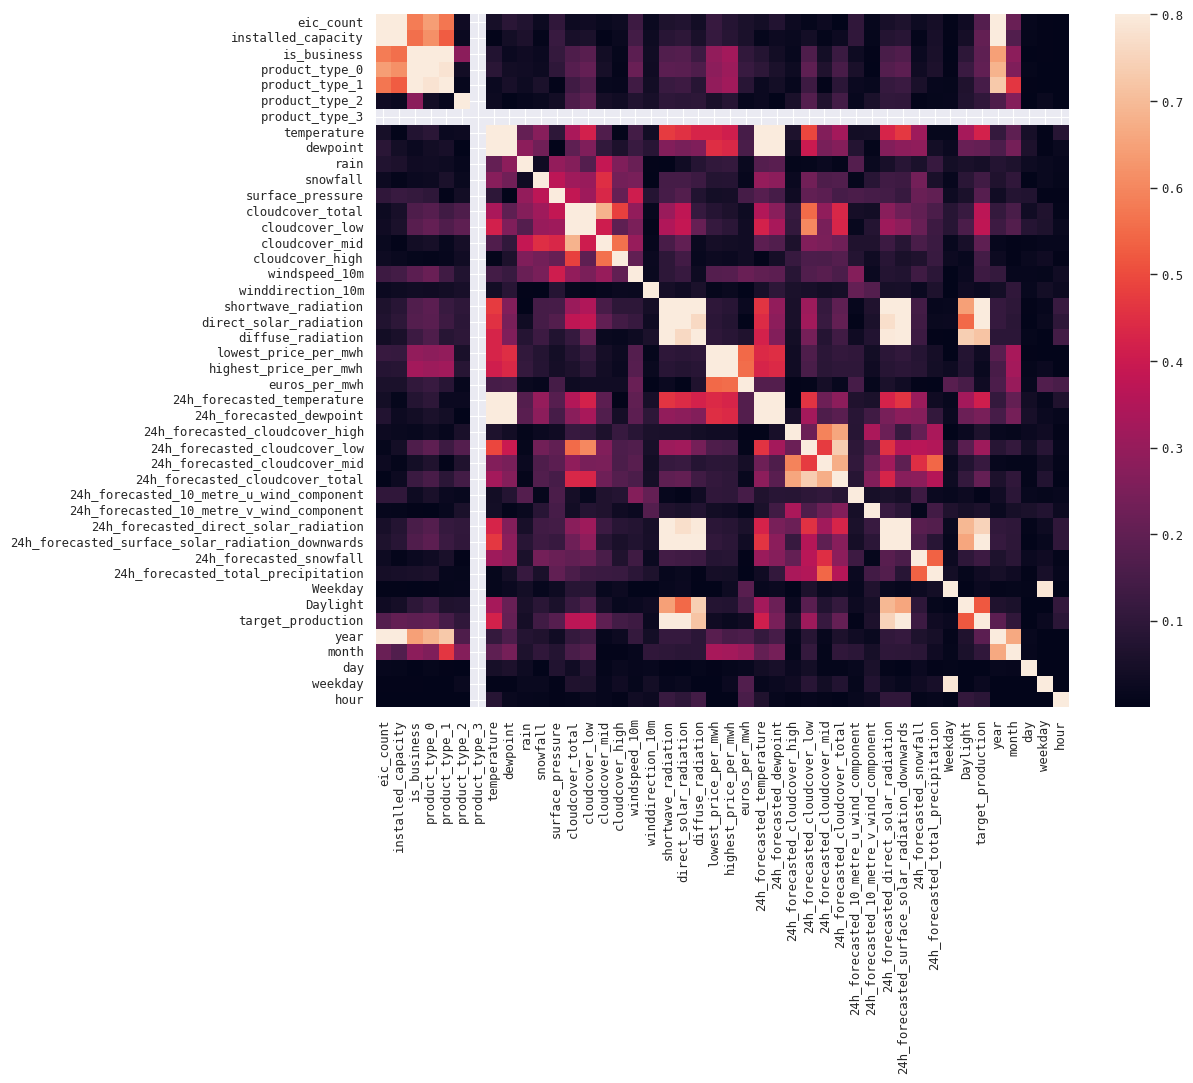

In [88]:


corrmat = feat_sel_df.drop(["target", "supply", "demand"], axis=1).corr(method='pearson', min_periods=1000)
# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = True, yticklabels = True)

In [89]:
#list correlations >0.9
corrmat = corrmat.unstack().reset_index()
corrmat.columns = ['feature1', 'feature2', 'correlation']
corrmat = corrmat[corrmat['feature1'] != corrmat['feature2']]
corrmat['correlation'] = np.abs(corrmat['correlation'])


In [90]:
corrmat = corrmat.sort_values(by='correlation', ascending=False)
corrmat = corrmat[corrmat['correlation'] > 0.8]
corrmat

,feature1,feature2,correlation
1,eic_count,installed_capacity,0.993818
44,installed_capacity,eic_count,0.993818
946,lowest_price_per_mwh,highest_price_per_mwh,0.981221
989,highest_price_per_mwh,lowest_price_per_mwh,0.981221
811,shortwave_radiation,direct_solar_radiation,0.975206
854,direct_solar_radiation,shortwave_radiation,0.975206
1691,target_production,direct_solar_radiation,0.969534
874,direct_solar_radiation,target_production,0.969534
1124,24h_forecasted_dewpoint,24h_forecasted_temperature,0.959322
1081,24h_forecasted_temperature,24h_forecasted_dewpoint,0.959322


[17:49:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



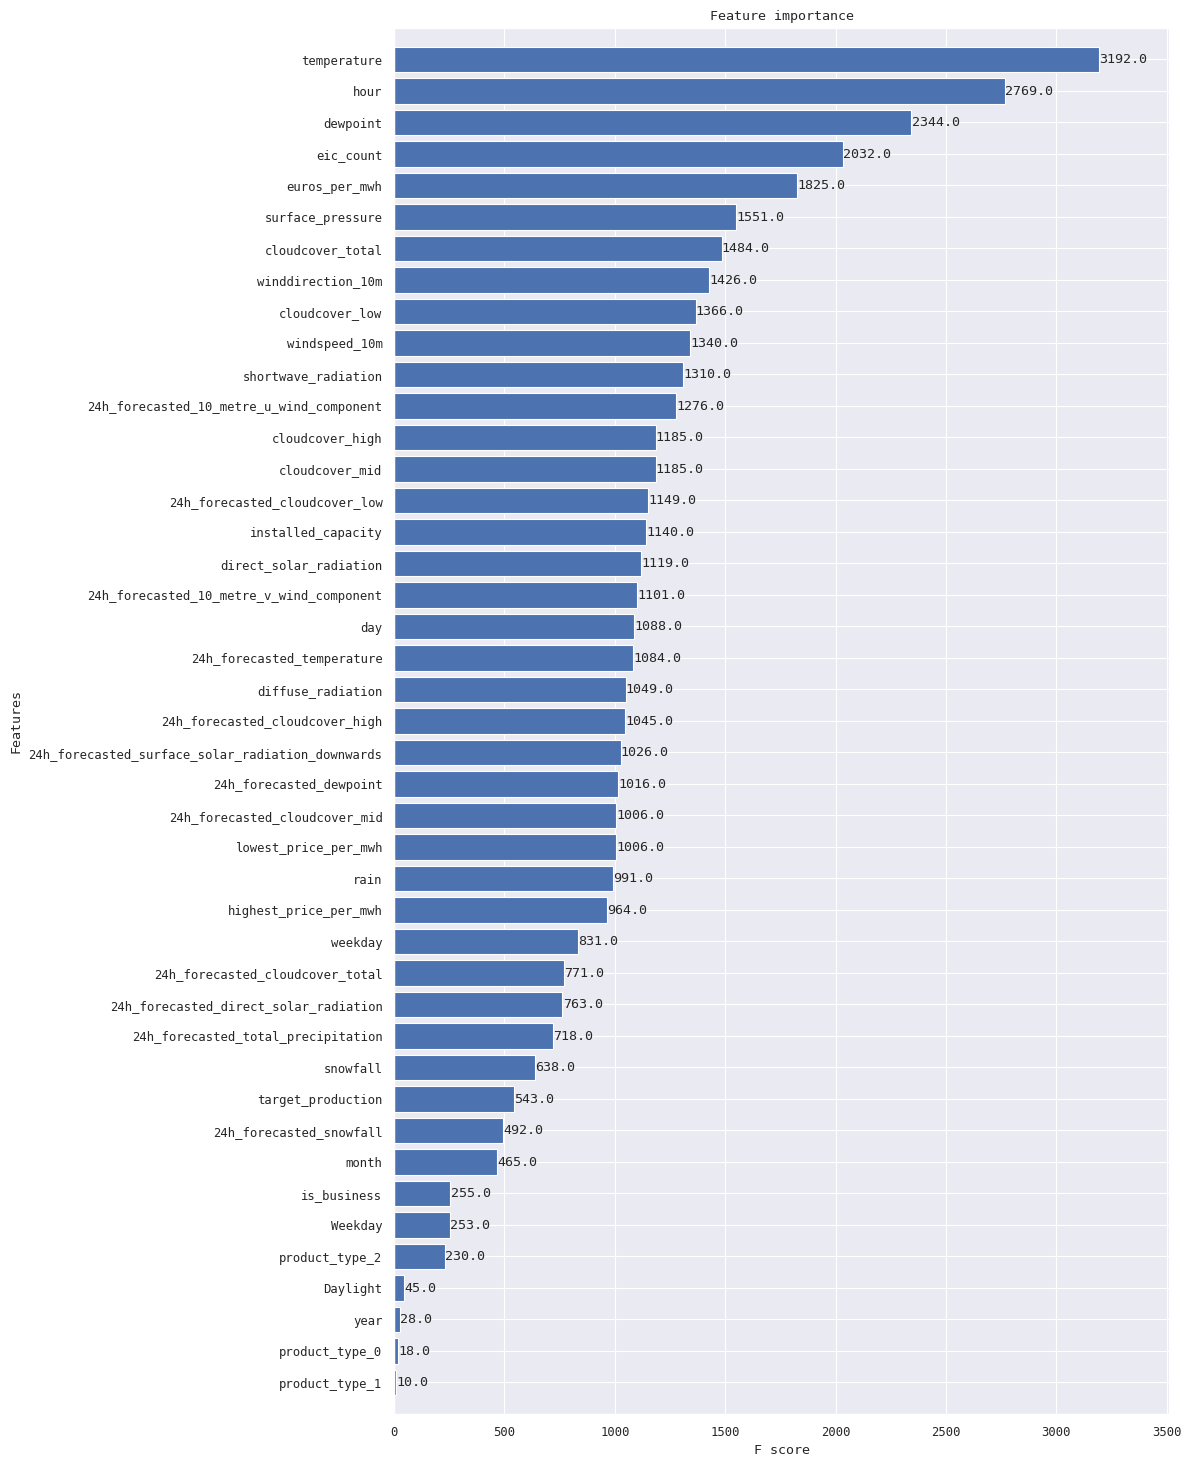

In [ ]:
# feature selection by xgb - for demand
import xgboost as xgb

train_y = feat_sel_df.demand
train_X = feat_sel_df.drop(["target", "supply", "demand"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()